# Advanced Statistics for Physics Analysis - Final assignment
## Learning the topology of a bayesian network from a database of cases using the K2 algorithm

### Load data
We tested our implementation of the K2 algorithm on two different datasets. The first ($D$) is the one provided by the original paper of Cooper and Herskovits which displays three general features ($x_1,x_2,x_3$) and $m=10$ cases. The second is a collecion of data taken from the National Basketball Association in the US, describing the performances of the "Philadelphia 76ers" team across the regular season of the national championship: its holds records for all the $m=72$ matches played reporting the final outcome ($W=1, L=0$), the opponent's strength (successfully qualified to the playoff or not), the match location (home/away) and the presence on the parquet of the 76ers proclamed best player Joel Embiid (for at least 25 minutes).

In [ ]:
require(dplyr)
library(bnlearn)
library(bnstruct)
library(Rgraphviz)



In [2]:
#First dataset
x1 <- c(1,1,0,1,0,0,1,0,1,0)
x2 <- c(0,1,0,1,0,1,1,0,1,0)
x3 <- c(0,1,1,1,0,1,1,0,1,0)

D <- data.frame(x1, x2, x3)

#Second dataset
myfile <- read.csv('Phila_2021.csv', header=TRUE)
D.76 <- data.frame(myfile)

head(D)
head(D.76)

Warning message in file(file, "rt"):
“cannot open file 'Phila_2021.csv': No such file or directory”


ERROR: Error in file(file, "rt"): non posso aprire questa connessione


### Algorithm implementation
The pseudo-code for the algorithm is provided in [ref2] together with the explicit calculations for the first dataset we investigate. Here we define the whole loop as a function of the dataset and the maximum number of parents we allow a given node to have. Please notice that the original algorithm requires also an ordered list of the nodes, to set possible conditional dependences. To simplify the visualization, we require in here that the input dataset has its columns already ordered so to match the node list mentioned above. Hence, it would be sufficient yet required to prepare the dataframe according to this costraint.

In [26]:
k2.algorithm <- function(data, max.parents){
    
    nodes <- names(data)
    n <- ncol(data)
    k2.score <- 0
    
    dag <- empty.graph(nodes=nodes)
    
    
    for (i in 1:n) {
        parent <- character()
        p.old <- log.score(i, parent, data)
      
        proceed <- TRUE
        pred_xi <- nodes[1:i-1]
        
        while (proceed & (length(parent)<max.parents)) {
            
            set <- setdiff(pred_xi, parent)
            unions <- lapply(set, union, parent)
            new.parent <- unlist(unions[which.max(sapply(unions, function(x) log.score(i, x, data)))])
            p.new <- log.score(i, new.parent, data)
                                                        

            if ( p.new > p.old ) {
                p.old <- p.new
                parent <- new.parent
                for (p in new.parent){
                      dag <- set.arc(dag, from=p, to=nodes[i])
                }
                
            }
            else {
                proceed <- FALSE
            } 
        }
        if (length(parent)>0) {
                    cat('node', nodes[i], 'has parents', parent, '\n')
        }
        else {
              cat('node', nodes[i], 'has  no parents \n')
        }
        
        
        k2.score <- k2.score+p.old
    }
    graphviz.plot(dag)
   
    
    
    

}

The code above makes use of a scoring function to rank the most probable parents sets. This is provided in che cell below, according to the theoretical model:

$$
f(i,\pi_i) = \prod_{j=1}^{q_i}\frac{\left(r_i - 1\right)!}{\left(N_{ij} + r_i - 1\right)!}\prod_{k=1}^{r_i}\alpha_{ijk}!
$$

Where we used the notation expressed in [ref2]. It is important to notice that at the beginning of each iteration of the algorithm, since it works in a grid way by filling subsequently an initially empty set of parents for each node $i$, the value of $q_i$ always starts with $0$ and thus we must be careful on the first product which ranges from $j=1$ to $j=0$. In fact, we cannot use the standard convention since this will lead to $f(i,\emptyset) = 1$, so maximum probability, and thus the algorithm will be stuck assigning to each node no parents. Hence, as suggested in [ref2], we simply ignore the $j$ index. Indeed, this allows to simplify the equation above and since the case of empty parents set as input is quite frequent we profile the function so to distinguish the cases.

The $\alpha$ values, consisting on the number of counts of a given parents sequence in the dataframe, are naturally returned by the "table( )" method of data.frame in R. 

In [3]:
myscore <- function(pi, i, D){
    # number of possible ourcomes for node i
    r = length(unique(D[,i]))  
    # generalized formula for no-parent case (from paper)
    if (length(pi) == 0){
        alpha = table(D[i])
        N = sum(alpha)
        prob = factorial(r-1)/factorial(N+r-1)*prod(sapply(alpha,factorial))
    }
    # standard formula (from paper)
    else{ 
        D2 = cbind(D[i],D[pi])
        alpha = table(D2)
        if (length(dim(alpha))>2){dim(alpha)=c(r,length(alpha)/r)}
        alpha = t(alpha)
        N.j = rowSums(alpha)
        M.j = apply(apply(alpha, c(1,2), factorial),1,prod)
        prob = prod(apply(cbind(N.j,M.j),1, function(x) x[2]*factorial(r-1)/factorial(x[1] + r - 1))) 
    }
    prob
}      

Since the product operations componing the score function can be expansive for large dataset, we implement also a logarithmic version of it. This allows to simply commputations turning products into sum. Eventually it will be sufficient to take the exponential of the log-score to retrive the posterior probability of a specific network. Exploting the probability of logarithms and recalling that 
$$
\log(n!) = \log\left(\prod_{x=1}^n x \right) = \sum_{x=1}^n \log(x)
$$
The log-score becomes:

$$
L := \log(f) = \sum_{j=1}^{q_j} \log_{f_j} \text{ where } \\
     \log(f_j) = \log\left[\left(r_i - 1\right)!\right] - \log\left[\left(N_{ij} + r_i - 1\right)!\right] + 
\log\left[\prod_{k=1}^{r_i}\alpha_{ijk}!\right] = \\
   = \sum_{x=1}^{r_i - 1}\log(x) - \sum_{y=1}^{N_{ij} + r_i - 1}\log(y) + \sum_{k=1}^{r_i}\sum_{z=1}^{\alpha_{ijk}}\log(z)
$$

Hence the log-score function can be simply obtained by summing logarithm of sequence of values, which is easy in R due to the comfort of the "apply" family methods. 

In [4]:
# pi, q, r, alpha are referred to index i
# i = nome del nodo i-esimo

#Calculate posterior probability of parents pi of node i
log.score <- function(i, pi, D){
    # number of possible ourcomes for node i
    r = length(unique(D[,i])) 
    # generalized formula for no-parent case (from paper)
    if (length(pi) == 0){
        alpha = table(D[i])
        N = sum(alpha)
        prob = (sum(sapply(1:(r-1),log))-sum(sapply(1:(N+r-1),log))+sum(sapply(alpha,function(a) ifelse(a==0,0,sum(sapply(1:a,log)))))) #%>% exp()                                                                      
    }
    # standard formula (from paper)
    else{ 
        D2 = cbind(D[i],D[pi])
        alpha = table(D2)
        if (length(dim(alpha))>2){dim(alpha)=c(r,length(alpha)/r)}
        alpha = t(alpha)
        N.j = rowSums(alpha)
        M.j = apply(alpha,c(1,2),function(a) ifelse(a==0,0,sum(sapply(1:a,log)))) %>% apply(1,sum)
        prob = (sum(apply(cbind(N.j,M.j),1, function(x) sum(sapply(1:(r-1),log))-sum(sapply(1:(x[1]+r-1),log))+x[2]))) #%>% exp()
        }
        prob
}          

node x1 has  no parents 
node x2 has parents x1 
node x3 has parents x2 


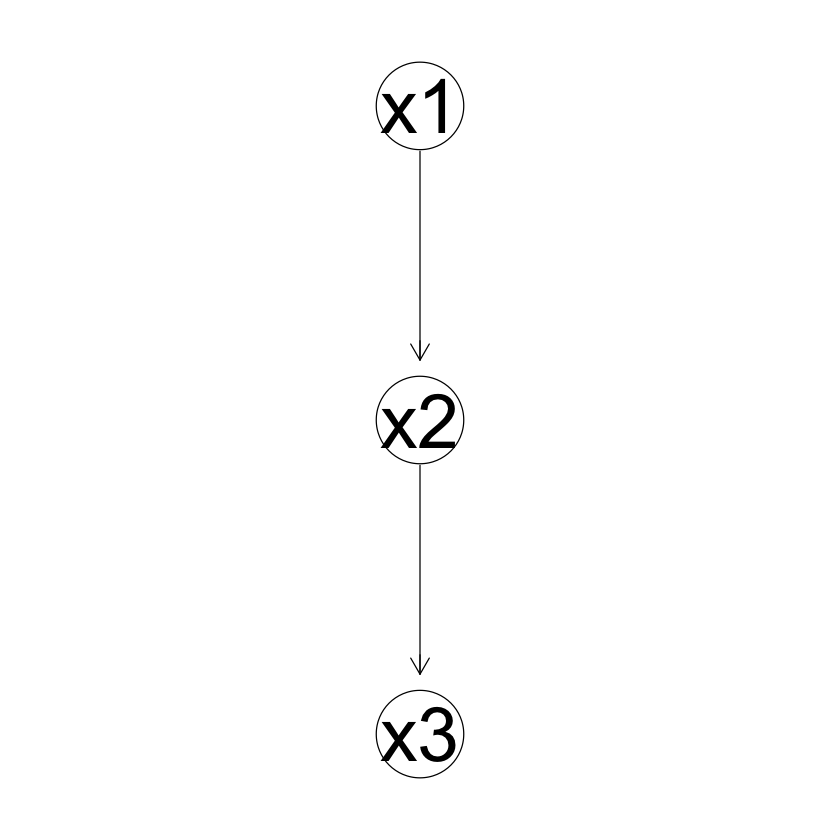

In [5]:
 k2 <- k2.algorithm(data = D, max.parents = 2)

In [5]:
k2

[1] 2.226854e-09

In [7]:
D_c <- data.frame(ifelse(D == 1, 'p', 'a'), stringsAsFactors = TRUE)

node x1 has no parents 
node x2 has parents{ x1 }
node x3 has parents{ x2 }


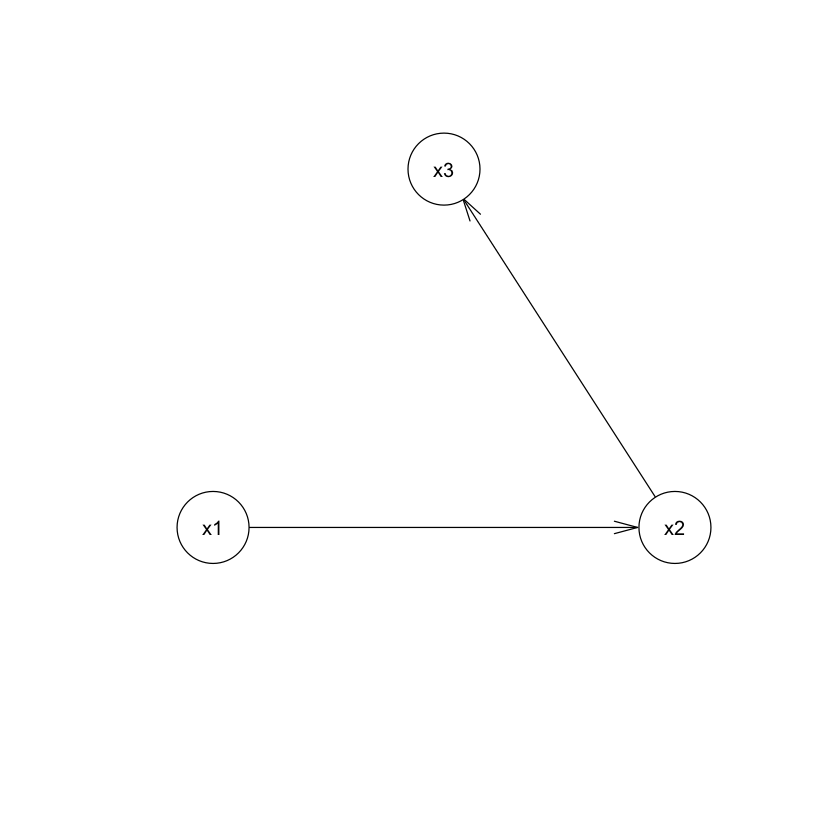

In [9]:
k2 <- k2.algorithm(data = D, max.parents = 2)

In [10]:
dag <- model2network('[x1][x2|x1][x3|x2]')
dag


  Random/Generated Bayesian network

  model:
   [x1][x2|x1][x3|x2] 
  nodes:                                 3 
  arcs:                                  2 
    undirected arcs:                     0 
    directed arcs:                       2 
  average markov blanket size:           1.33 
  average neighbourhood size:            1.33 
  average branching factor:              0.67 

  generation algorithm:                  Empty 


In [11]:
nparams(dag, D_c)

[1] 5

In [12]:
fit <- bn.fit(dag, data = D_c, method = 'bayes')

In [13]:
network <- BN()
print(network)

ERROR: Error in BN(): non trovo la funzione "BN"


In [ ]:
s <- score(dag, data = D_c, type = 'k2')

In [ ]:
exp(s)

In [ ]:
blacklist <- data.frame(from  = c('x2', 'x3', 'x3'), to = c('x1', 'x1', 'x2'))
blacklist

In [ ]:
fit <- hc(D_c, score = 'k2', blacklist = blacklist, maxp = 2)
fit

In [15]:
BND <- BNDataset(data = D,
                discreteness = rep('d', ncol(D)),
                variables = names(D),
                node.sizes = c(2,2,2),
                starts.from = 0)

In [16]:
str(BND)

Formal class 'BNDataset' [package "bnstruct"] with 19 slots
  ..@ name             : chr "BNDataset"
  ..@ header.file      : chr ""
  ..@ data.file        : chr ""
  ..@ variables        : chr [1:3] "x1" "x2" "x3"
  ..@ node.sizes       : num [1:3] 2 2 2
  ..@ num.variables    : int 3
  ..@ discreteness     : logi [1:3] TRUE TRUE TRUE
  ..@ quantiles        : NULL
  ..@ num.items        : int 10
  ..@ has.raw.data     : logi TRUE
  ..@ has.imputed.data : logi FALSE
  ..@ raw.data         : num [1:10, 1:3] 2 2 1 2 1 1 2 1 2 1 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : NULL
  .. .. ..$ : chr [1:3] "x1" "x2" "x3"
  ..@ imputed.data     : num [1, 1] 0
  ..@ has.boots        : logi FALSE
  ..@ boots            :List of 1
  .. ..$ : NULL
  ..@ has.imputed.boots: logi FALSE
  ..@ imp.boots        :List of 1
  .. ..$ : NULL
  ..@ num.boots        : num 0
  ..@ num.time.steps   : num 1


In [23]:
for (algorithm in c("sm", "mmhc", "sem", "mmpc", "hc")){
    bnet <- learn.network(BND, layering = c(1,2,3), scoring.func='k2', algo=algorithm)
    print(bnet) 
}


bnstruct :: learning the structure using SM ...

bnstruct :: learning using SM completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.




Bayesian Network: BNDataset

num.nodes 3

variables
x1 x2 x3
discreteness
TRUE TRUE TRUE
node.sizes
2 2 2
Adjacency matrix:
   x1 x2 x3
x1  0  1  1
x2  0  0  1
x3  0  0  0

Conditional probability tables:$x1
x1
  1   2 
0.5 0.5 

$x2
   x2
x1          1         2
  1 0.7727273 0.2272727
  2 0.2272727 0.7727273

$x3
, , x3 = 1

   x2
x1          1          2
  1 0.7352941 0.10000000
  2 0.9000000 0.02941176

, , x3 = 2

   x2
x1          1         2
  1 0.2647059 0.9000000
  2 0.1000000 0.9705882





bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.




Bayesian Network: BNDataset

num.nodes 3

variables
x1 x2 x3
discreteness
TRUE TRUE TRUE
node.sizes
2 2 2
Adjacency matrix:
   x1 x2 x3
x1  0  1  1
x2  0  0  1
x3  0  0  0

Conditional probability tables:$x1
x1
  1   2 
0.5 0.5 

$x2
   x2
x1          1         2
  1 0.7727273 0.2272727
  2 0.2272727 0.7727273

$x3
, , x3 = 1

   x2
x1          1          2
  1 0.7352941 0.10000000
  2 0.9000000 0.02941176

, , x3 = 2

   x2
x1          1         2
  1 0.2647059 0.9000000
  2 0.1000000 0.9705882





bnstruct :: learning the structure using SEM ...

... bnstruct :: no missing values found, learning the network once

... bnstruct :: learning the structure using MMHC ...

... bnstruct :: learning using MMHC completed.

... bnstruct :: learning network parameters ... 

... bnstruct :: parameter learning done.

bnstruct :: learning using SEM completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.




Bayesian Network: BNDataset

num.nodes 3

variables
x1 x2 x3
discreteness
TRUE TRUE TRUE
node.sizes
2 2 2
Adjacency matrix:
   x1 x2 x3
x1  0  1  1
x2  0  0  1
x3  0  0  0

Conditional probability tables:$x1
x1
  1   2 
0.5 0.5 

$x2
   x2
x1          1         2
  1 0.7727273 0.2272727
  2 0.2272727 0.7727273

$x3
, , x3 = 1

   x2
x1          1          2
  1 0.7352941 0.10000000
  2 0.9000000 0.02941176

, , x3 = 2

   x2
x1          1         2
  1 0.2647059 0.9000000
  2 0.1000000 0.9705882





bnstruct :: learning the structure using MMPC ...

bnstruct :: learning using MMPC completed.




Bayesian Network: BNDataset

num.nodes 3

variables
x1 x2 x3
discreteness
TRUE TRUE TRUE
node.sizes
2 2 2
WPDAG:
   x1 x2 x3
x1  0  1  1
x2  0  0  1
x3  0  0  0

Conditional probability tables:[[1]]
NULL




bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.




Bayesian Network: BNDataset

num.nodes 3

variables
x1 x2 x3
discreteness
TRUE TRUE TRUE
node.sizes
2 2 2
Adjacency matrix:
   x1 x2 x3
x1  0  1  1
x2  0  0  1
x3  0  0  0

Conditional probability tables:$x1
x1
  1   2 
0.5 0.5 

$x2
   x2
x1          1         2
  1 0.7727273 0.2272727
  2 0.2272727 0.7727273

$x3
, , x3 = 1

   x2
x1          1          2
  1 0.7352941 0.10000000
  2 0.9000000 0.02941176

, , x3 = 2

   x2
x1          1         2
  1 0.2647059 0.9000000
  2 0.1000000 0.9705882





In [ ]:
names(D.76)

In [ ]:
nodes <- c('Home','Opp_strength','Embiid','W')
n <- ncol(D.76)
u <- 3

for (i in 1:n) {
    parent <- character()
    p.old <- score(parent, i, D.76)
    proceed <- TRUE
    pred_xi <- nodes[1:i-1]

    while (proceed & (length(parent)<u)) {
        set <- setdiff(pred_xi, parent)
        unions <- lapply(set, union, parent)
        new.parent <- unlist(unions[which.max(sapply(unions, score, i, D.76))])
        p.new <- score(new.parent, i, D.76)
        if ( p.new > p.old ) {
            p.old <- p.new
            parent <- new.parent
        }
        else {
            proceed <- FALSE
        } 
    }
    cat('node', nodes[i], 'has parents: {', parent, '}\n')
}

In [ ]:
nodes <- names(D)
n <- ncol(D)
u <- 2

for (i in 1:n) {
    parent <- character()
    p.old <- score(parent, i, D)
    proceed <- TRUE
    pred_xi <- nodes[1:i-1]

    while (proceed & (length(parent)<u)) {
        set <- setdiff(pred_xi, parent)
        unions <- lapply(set, union, parent)
        new.parent <- unlist(unions[which.max(sapply(unions, score, i, D))])
        p.new <- score(new.parent, i, D)
        if ( p.new > p.old ) {
            p.old <- p.new
            parent <- new.parent
        }
        else {
            proceed <- FALSE
        } 
    }
    cat('node', nodes[i], 'has parents: {', parent, '}\n')
}

### Lung cancer 'toy' dataset
In order to check further the validity of our implementation, we test its performance on a well-known synthetic dataset, called the 'Asia' or 'Lung cancer' dataset, proposed in 1988 by S. Lauritzen and D. Spiegelhalter in 'Local Computation with Probabilities on Graphical Structures and their Application to Expert Systems (with discussion)'.


The dataset is made of 10000 observation of 8 binary variables, encoded as two-level factors, each one with levels 'yes' or 'no', marking the presence or absence of the effect for that specific observation.
The observed variables are the following:
* Asia: has the patient recently visited Asia?
* Smoke: does the patient smoke?
* Tub: does he/she have tuberculosis?
* Lung: does he/she have lung cancer?
* Bronc: does he/she have bronchitis?
* Either: does he/she have either tuberculosis or lung cancer?
* Dysp: does he/she have dyspnoea?
* Xrays: does he/she have positive x-rays?

Lauritzen and Spiegelhalter explain the choice of the model as follows:

“Shortness-of-breath (dyspnoea) may be due to tuberculosis, lung cancer or bronchitis, or none of them, or more than one of them. A recent visit to Asia increases the chances of tuberculosis, while smoking is known to be a risk factor for both lung cancer and bronchitis. The results of a single chest X-ray do not discriminate between lung cancer and tuberculosis, as neither does the presence or absence of dyspnoea.”

The dataset and the expected bayesian network is the following:

  asia tub smoke lung bronc either xray dysp
1   no  no    no   no    no     no   no  yes
2   no  no   yes   no    no     no   no   no
3   no  no    no   no    no     no   no   no
4   no  no   yes   no    no     no   no   no
5   no  no   yes   no   yes     no   no  yes
6   no  no   yes   no    no     no   no   no


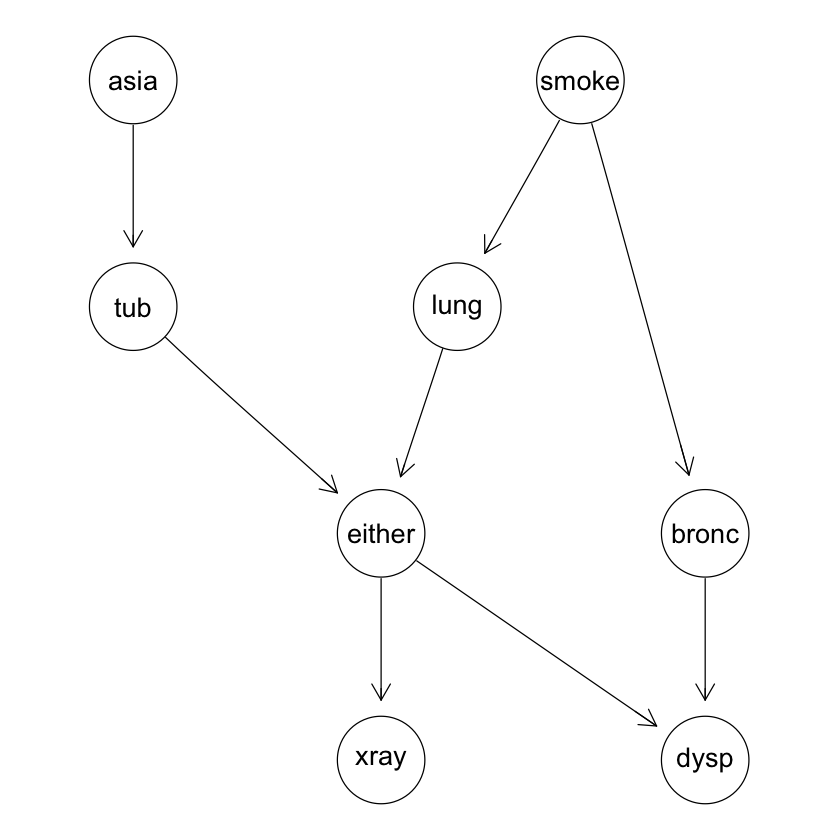

In [134]:
dag <- model2network('[smoke][asia][tub|asia][lung|smoke][bronc|smoke][either|tub:lung][dysp|bronc:either][xray|either]')
graphviz.plot(dag)
dataset <- read.csv('https://www.ccd.pitt.edu//wiki/images/ASIA10k.csv', header=T)
print(head(dataset))


After importing the dataset, we order its colunms following the 'prior' information given on the relationship between variables, as requested by the K2 algorithm: 'smoke' and 'asia' variables are set as roots node, whereas 'xray' and 'dysp' are the leaves of the DAG.

In addition, we set the max number of parents to 2 for each node.

Finally, we test on this dataset the K2 algorithm we implemented, that leads to the following results:

node smoke has  no parents 
node asia has  no parents 
node tub has  no parents 
node bronc has parents smoke 
node lung has parents smoke 
node either has parents tub lung 
node xray has parents either 
node dysp has parents either bronc 


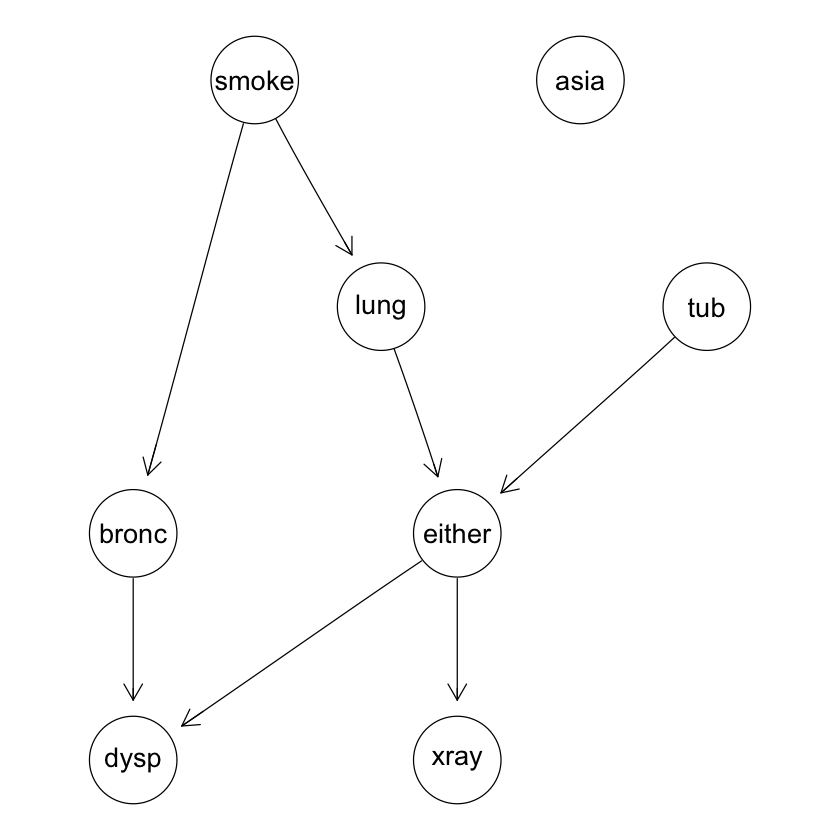

In [135]:
dataset[,] <- ifelse(dataset[,]=='yes',1,0)
col_order <- c('smoke', 'asia', 'tub', 'bronc', 'lung', 'either', 'xray', 'dysp' )
#col_order <- c('asia', 'smoke', 'tub', 'lung', 'either', 'bronc', 'xray', 'dysp')
dataset <- dataset[, col_order]
k2.algorithm(data=dataset, max.parents=2)

As we can see, the network structure is inferred correctly except for the arch going from 'asia' to 'tub': to understand this behaviour we impose the theoretical structure of the network and compute the correspondent conditional probabilities, exploiting the fit() function of the 'bnlearn' built-in package.
It is possible to observe that for both the presence and the absence of the 'visit to asia' feature, the conditional probabilities of tuberculosis are comparable.


  Parameters of node tub (multinomial distribution)

Conditional probability table:
 
   asia
tub           a           p
  a 0.990084271 0.954054054
  p 0.009915729 0.045945946

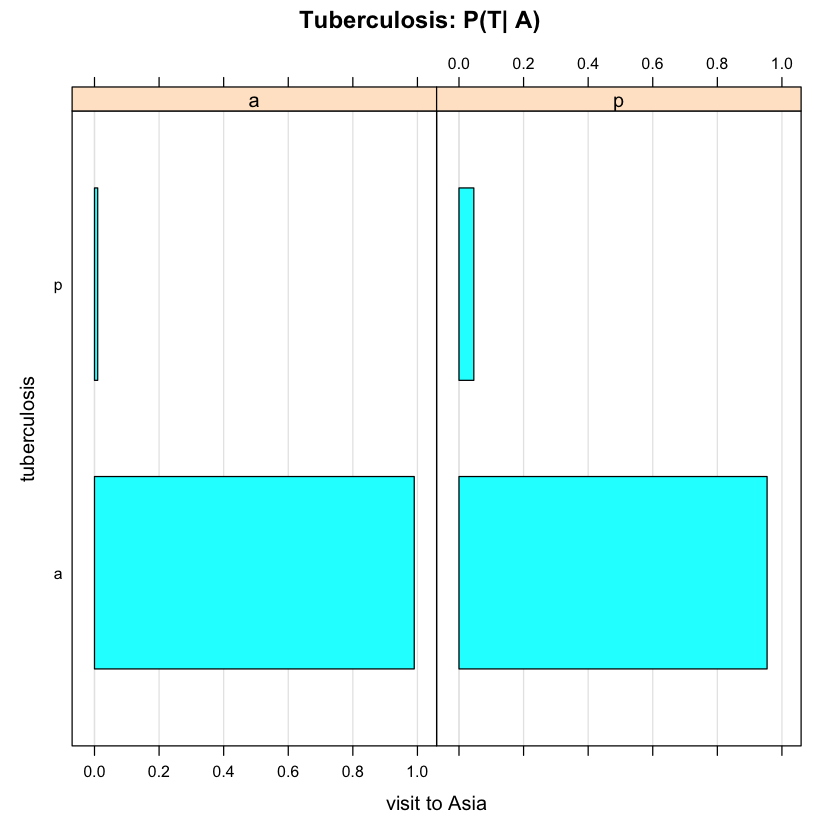

In [137]:
data.f <- data.frame(ifelse(dataset == 1, 'p', 'a'), stringsAsFactors = TRUE)
dag <- model2network('[smoke][asia][tub|asia][lung|smoke][bronc|smoke][either|tub:lung][dysp|bronc:either][xray|either]')
bn.bayes <- bn.fit(dag, data = data.f, method = "bayes")
bn.bayes$tub
bn.fit.barchart(bn.bayes$tub, main = "Tuberculosis: P(T| A)", xlab = "visit to Asia", ylab = "tuberculosis")
#bn.bayes$bronc
#bn.fit.barchart(bn.bayes$bronc, main = "Bronchitis: P(B| S)", xlab = "smoker", ylab = "bronchitis")


In [111]:
ci.test('tub', c('asia'), test = 'mi', data = data.f)


	Mutual Information (disc.)

data:  tub ~ asia  
mi = 5.6746, df = 1, p-value = 0.01721
alternative hypothesis: true value is greater than 0


In [117]:
pt_a <- as.vector(coefficients(bn.bayes$tub)[2,])
p_a <-as.vector(coefficients(bn.bayes$asia))
p_t <- sum(pt_a * p_a)
p_t
p_a
pt_a

[1] 0.01024898

[1] 0.990750925 0.009249075

[1] 0.009915729 0.045945946

#### bnlearn structure learning
We now perform the structure guessing with the bnlearn hc() built-in function, that performs the network guessing with the hill-climbing algorithm. In addition, it is possible to choose the scoring function from a given set: we choose to test the 'k2' scoring function and the 'bde' scoring function. 
The 'k2' score retrieve the 'partial' network with the missing arch from 'asia' and 'tub' variables.
On the other hand, the BDe score guesses the proper structure. Then, we can visualize its strength plot and retrieve numerically the archs' strength:
the 'asia'-'tub' connection is from 3  to 4 orders of magnitude weaker than the other connections.


    from     to      strength
1  bronc   dysp -2719.0248634
2   lung either -2068.1423248
3 either   xray -1506.9648873
4    tub either  -537.3965664
5  smoke  bronc  -456.9110676
6 either   dysp  -285.4754725
7  smoke   lung  -206.1642211
8   asia    tub    -0.5863799


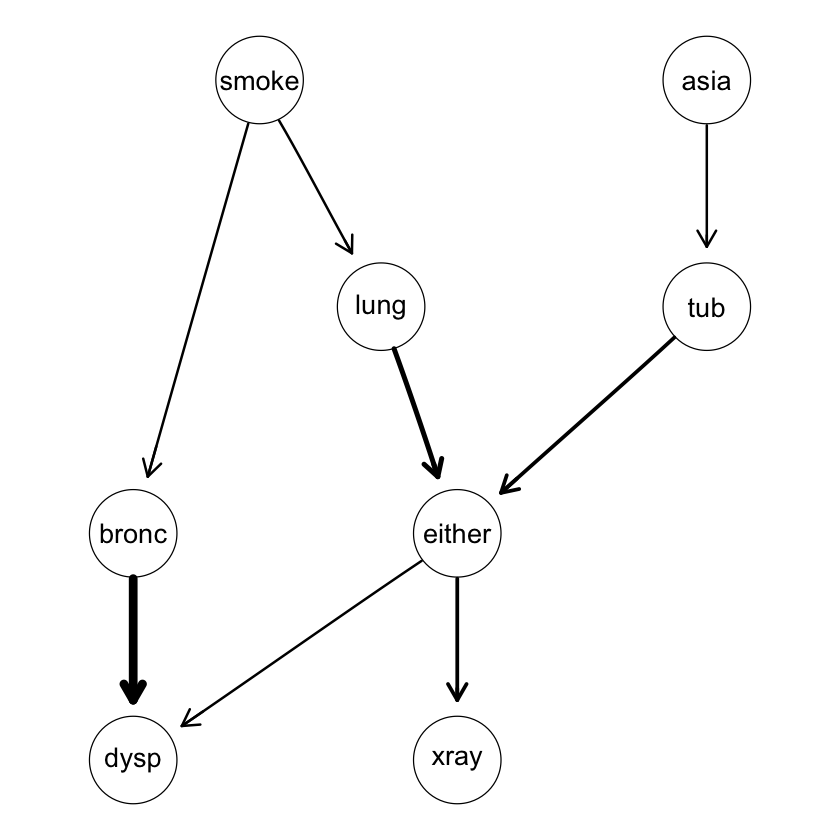

In [142]:
blacklist <- data.frame(from  = c('tub', 'either','smoke','lung','bronc', 'dysp', 'xray',
                                 'tub', 'either','asia','lung','bronc', 'dysp', 'xray',
                                 'tub', 'asia', 'dysp', 'dysp', 'dysp', 'dysp', 'dysp',
                                 'xray', 'xray', 'xray', 'xray', 'xray', 
                                  'either', 'either', 'either'
                                 ),
                                
                        
                        to = c(rep('asia', 7), 
                               rep('smoke', 7),
                               'lung', 'xray', 'lung', 'bronc', 'either', 'tub', 'xray',
                               'either', 'bronc', 'lung', 'tub', 'dysp', 
                               'tub', 'lung', 'bronc'
                               ))

fit_bde <- hc(data.f, score = 'bde', 
          blacklist = blacklist, maxp = 2)

strength.plot(fit, arc.strength(fit_bde, data.f))
print(arc.strength(fit, data.f))


## bnctruct k2 implementation: test with asia dataset
Finally, we test our implementation of the k2 scoring function inside the bnstruct library on top of the hill-climbing algorithm. 
Again, the k2 scoring is not able to guess the weak 'tuberculosis' vs 'asia' dependence, but retrieve, all in all, the correct graph.

bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



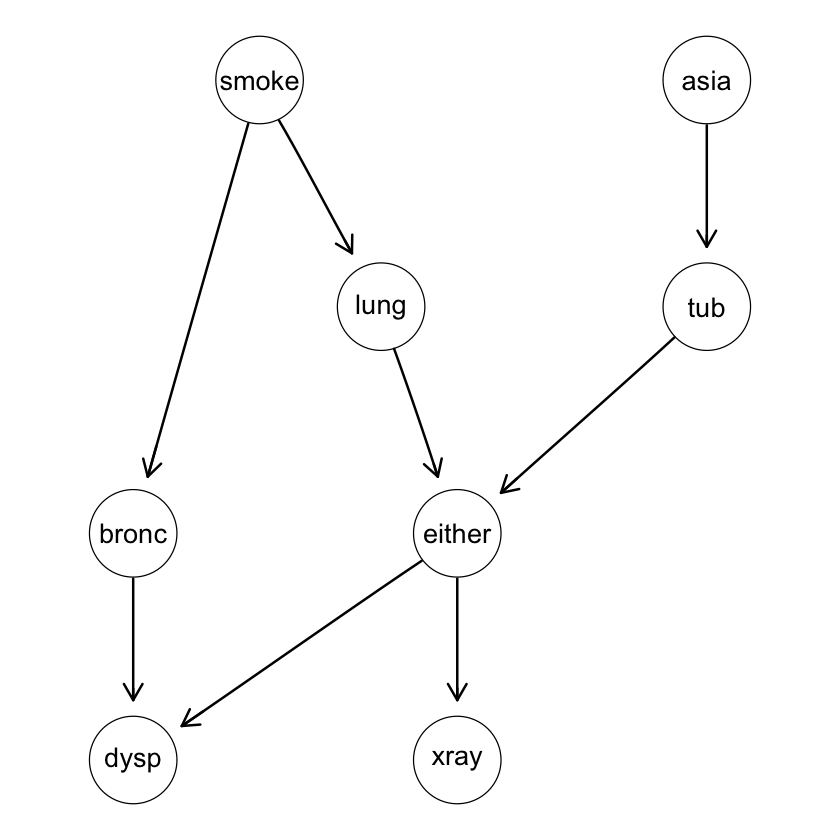

In [22]:
BNasia <- BNDataset(data = dataset,
                discreteness = rep('d', ncol(dataset)),
                variables = names(dataset),
                node.sizes = rep(c(2), 8) ,
                starts.from = 0)

bnet <- learn.network(BNasia, algo='hc', scoring='k2',layering=1:8)
plot(bnet)